<a href="https://www.kaggle.com/code/hoanganh4511/text-classification-using-lstm?scriptVersionId=132229325" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.utils import resample

In [2]:
df = pd.read_csv("/kaggle/input/emotions-in-text/Emotion_final.csv")

In [3]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


<AxesSubplot:xlabel='Emotion', ylabel='count'>

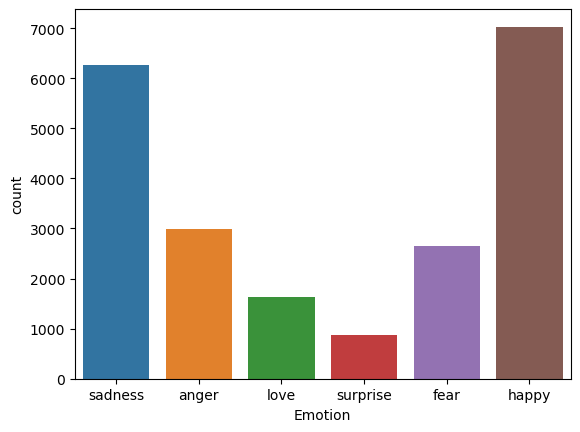

In [4]:
sns.countplot(x = "Emotion", data = df)

In [5]:
# upsample surprise
n_surp_sample = 1000
surp = df[df["Emotion"] == "surprise"]
surp_upsample = resample(surp, random_state = 35, n_samples=n_surp_sample, replace = True)

# upsample love
n_love_sample = 500
love = df[df["Emotion"] == "love"]
love_upsample = resample(love, random_state = 35, n_samples=n_love_sample, replace = True)

df = pd.concat([df, surp_upsample, love_upsample])

<AxesSubplot:xlabel='Emotion', ylabel='count'>

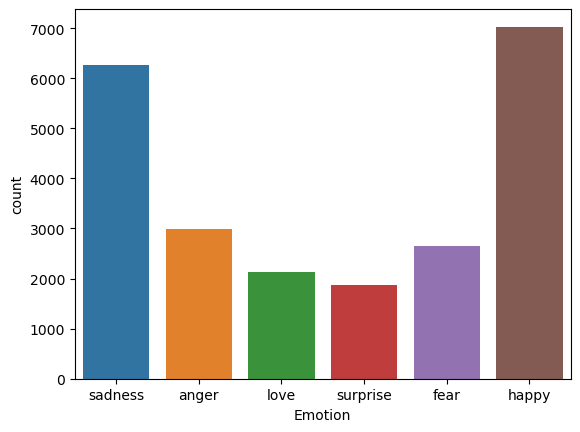

In [6]:
sns.countplot(x = "Emotion", data = df)

<AxesSubplot:>

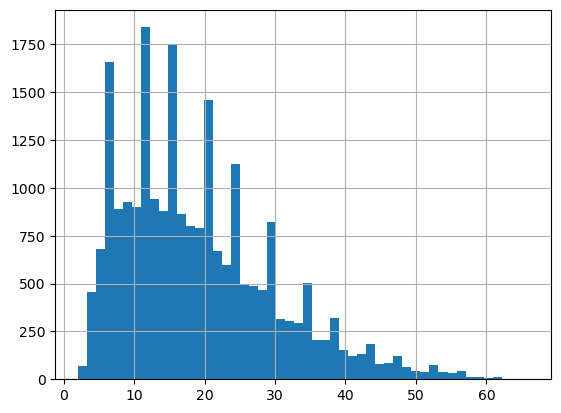

In [7]:
seq_len = (len(i.split()) for i in df['Text'])
pd.Series(seq_len).hist(bins = 50)

In [8]:
encoder = OneHotEncoder()
X = np.array(df.Text)
y = encoder.fit_transform(np.array(df.Emotion).reshape(-1,1)).toarray()

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [10]:
tokenize_data = Tokenizer(oov_token='<UNK>', split=" ")
tokenize_data.fit_on_texts(X)

In [11]:
tokenize_train = tokenize_data.texts_to_sequences(X_train)
vec_train = pad_sequences(tokenize_train, padding="post", maxlen=50)

tokenize_val = tokenize_data.texts_to_sequences(X_val)
vec_val = pad_sequences(tokenize_val, padding="post", maxlen=50)

tokenize_test = tokenize_data.texts_to_sequences(X_test)
vec_test = pad_sequences(tokenize_test, padding="post", maxlen=50)

vocab_size = len(tokenize_data.word_index) + 1

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [13]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=50))
model.add(Bidirectional(LSTM(units=256, dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units=256, dropout=0.2, return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
# model.add(Dense(units=512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
# model.add(Dense(units=256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=6, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           2465280   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 512)          788480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 512)          1574912   
 nal)                                                            
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                        

In [14]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model.pth", monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto')
t = time.time()
his = model.fit(x=vec_train, y=y_train, batch_size=128, epochs=30, validation_data=(vec_val, y_val), callbacks = [checkpoint])
print(f'Time taken: {time.time() - t}')

Epoch 1/30
146/146 [==============================] - 71s 364ms/step - loss: 1.5709 - accuracy: 0.3913 - val_loss: 1.7523 - val_accuracy: 0.2762
Epoch 2/30
146/146 [==============================] - 40s 278ms/step - loss: 0.5923 - accuracy: 0.7887 - val_loss: 1.4798 - val_accuracy: 0.4896
Epoch 3/30
146/146 [==============================] - 9s 65ms/step - loss: 0.1859 - accuracy: 0.9390 - val_loss: 1.4204 - val_accuracy: 0.4814
Epoch 4/30
146/146 [==============================] - 38s 261ms/step - loss: 0.1074 - accuracy: 0.9646 - val_loss: 0.7441 - val_accuracy: 0.7426
Epoch 5/30
146/146 [==============================] - 36s 248ms/step - loss: 0.0761 - accuracy: 0.9748 - val_loss: 1.1333 - val_accuracy: 0.7833
Epoch 6/30
146/146 [==============================] - 8s 57ms/step - loss: 0.0625 - accuracy: 0.9801 - val_loss: 3.8445 - val_accuracy: 0.5036
Epoch 7/30
146/146 [==============================] - 8s 54ms/step - loss: 0.0527 - accuracy: 0.9827 - val_loss: 1.3369 - val_accuracy

In [15]:
# import matplotlib.pyplot as plt
# plt.plot(his.history['loss'], label="Train loss")
# plt.plot(his.history['val_loss'], label="Val loss")
# plt.legend();

In [16]:
# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
class_names = ["anger", "fear", "happy", "love", "sadness", "surprise"]

def model_Evaluate(model, X_test, y_test):

    t = time.time()
    y_pred = model.predict(X_test)
    t = time.time() - t
    y_pred = y_pred.argmax(axis=-1)
    y_test = y_test.argmax(axis=-1)
    
    print(f'Prediction time: {t/len(y_pred)}')
    print(classification_report(y_test, y_pred))

    for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_predictions(
          y_test,
          y_pred,
          display_labels=class_names,
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)
      plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
      plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

In [17]:
model=tf.keras.models.load_model("/kaggle/working/model.pth")

72/72 [==============================] - 2s 9ms/step
Prediction time: 0.0011675971517994845
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       299
           1       0.88      0.86      0.87       265
           2       0.87      0.92      0.90       703
           3       0.79      0.83      0.81       214
           4       0.92      0.94      0.93       627
           5       0.99      0.80      0.89       188

    accuracy                           0.89      2296
   macro avg       0.90      0.87      0.88      2296
weighted avg       0.90      0.89      0.89      2296



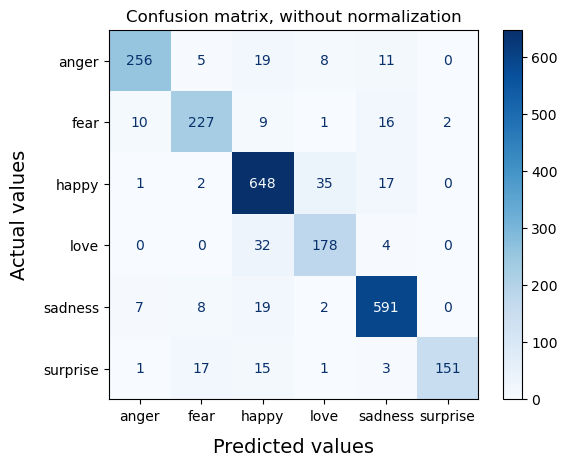

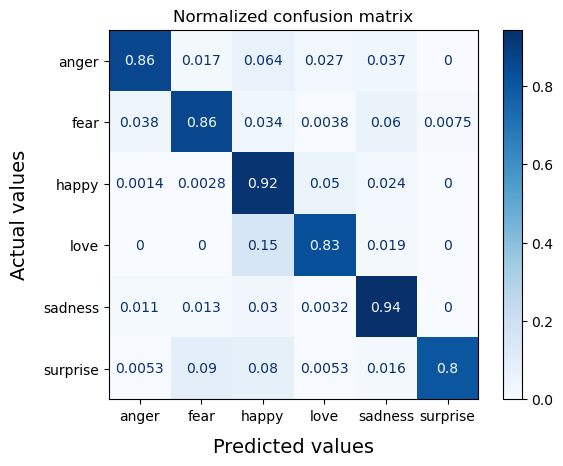

In [18]:
model_Evaluate(model=model, X_test=vec_test, y_test=y_test)